In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from pymatgen.util.plotting_utils import get_publication_quality_plot
from pyqe.qe_output import *

mpl.rcParams['axes.linewidth']=3
mpl.rcParams['lines.markeredgewidth']=3
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['lines.markersize']=5
mpl.rcParams['xtick.major.width']=3
mpl.rcParams['xtick.major.size']=8
mpl.rcParams['xtick.minor.width']=3
mpl.rcParams['xtick.minor.size']=4
mpl.rcParams['ytick.major.width']=3
mpl.rcParams['ytick.major.size']=8
mpl.rcParams['ytick.minor.width']=3
mpl.rcParams['ytick.minor.size']=4

15


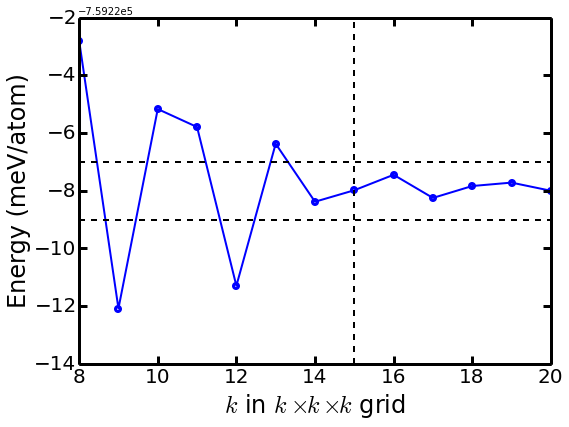

In [2]:
b1k = BasicAnalyzer('bcc_kpts.csv','nkpts',1)
df1k = analyze_kgrid(b1k)
plt1k = get_convergence_plot(df1k,'kgrid','energy',1)
plt1k.xlabel('$k$ in $k\\times k\\times k$ grid')
plt1k.ylabel('Energy (meV/atom)')
plt1k.tight_layout()
plt1k.savefig('bcc_kpts.pdf')

16


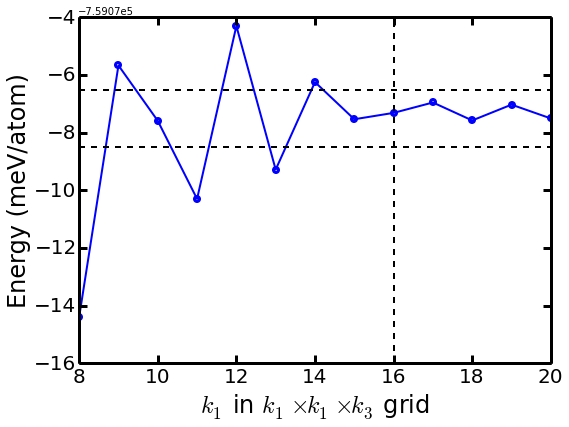

In [3]:
b2k = BasicAnalyzer('hcp_kpts.csv','nkpts',0.5)
df2k = analyze_kgrid(b2k)
plt2k = get_convergence_plot(df2k,'kgrid','energy',1)
plt2k.xlabel('$k_1$ in $k_1\\times k_1\\times k_3$ grid')
plt2k.ylabel('Energy (meV/atom)')
plt2k.tight_layout()
plt2k.savefig('hcp_kpts.pdf')

2.841804


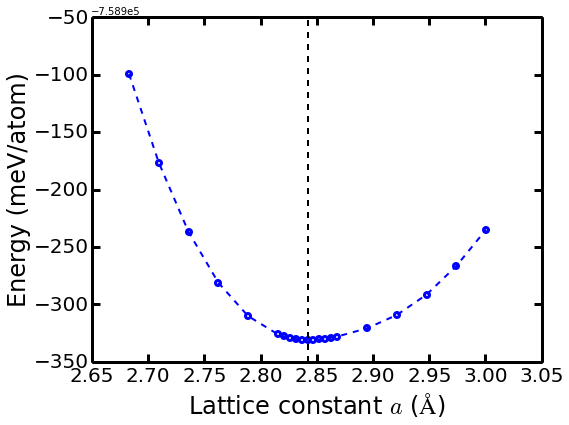

In [4]:
plt1l = get_ea_plot('bcc_latt.csv')
plt1l.ylabel('Energy (meV/atom)')
plt1l.tight_layout()
plt1l.savefig('bcc_latt.pdf')

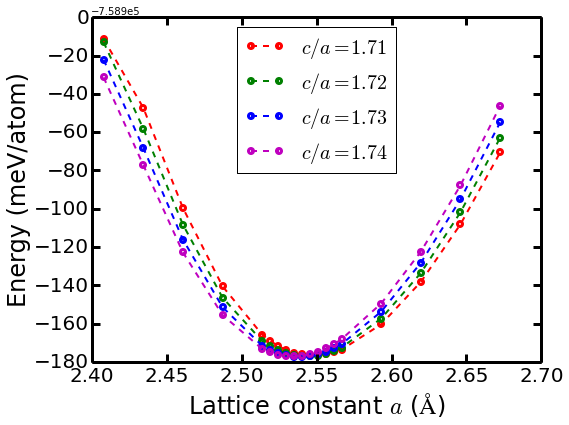

In [5]:
def get_hcp_latt_plot(csv_file):
    b = BasicAnalyzer(csv_file,e_scale=0.5)
    df = b.df
    plt = get_publication_quality_plot(8,6)
    cs = sorted(set(df['calat']))
    color = ['r','g','b','m']
    for i,c in enumerate(cs):
        cdf = df[df.calat==c]
        cdf = cdf.sort(columns='alat')
        plt.plot(cdf['alat'],cdf['energy'],'%so--' % color[i],
                 fillstyle='none',label='$c/a=%.2f$' % c)
    plt.xlabel('Lattice constant $a$ ($\AA$)')
    plt.legend(loc=0,fontsize=20)
    return plt

plt2l = get_hcp_latt_plot('hcp_latt.csv')

plt2l.ylabel('Energy (meV/atom)')
plt2l.tight_layout()
plt2l.savefig('hcp_latt.pdf')

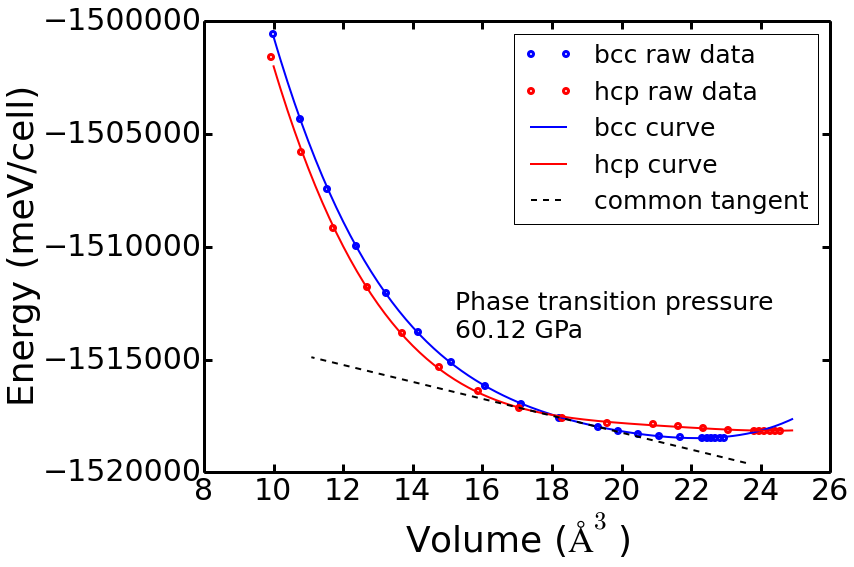

In [6]:
from math import sqrt
from scipy.optimize import fsolve

def get_dfs():
    b = BasicAnalyzer('press.csv')
    df = b.df
    bcc = df[df.calat==0]
    bcc = bcc.sort(columns='alat')
    bcc['volume'] = bcc['alat']**3
    bcc['energy'] *=2
    c = 1.73
    hcp = df[df.calat==c]
    hcp = hcp.sort(columns='alat')
    hcp['volume'] = sqrt(3)/2*c*hcp['alat']**3
    return bcc,hcp

def get_poly_params(df):
    z = np.polyfit(df['volume'],df['energy'],4)
    p = np.poly1d(z) #4-degree polynomial
    pk = p.deriv() #first derivative of p, used as the slope of tangent line
    pb = pk * np.poly1d([-1,0]) + p #intercept of tangent line
    return p,pk,pb

def get_ev_plot():
    bcc,hcp = get_dfs()
    plt = get_publication_quality_plot(12,8)
    plt.plot(bcc['volume'],bcc['energy'],'bo',fillstyle='none',label='bcc raw data')
    plt.plot(hcp['volume'],hcp['energy'],'ro',fillstyle='none',label='hcp raw data')
    X = np.arange(10,25,0.1)
    p1,pk1,pb1 = get_poly_params(bcc)
    plt.plot(X,p1(X),'b-',label='bcc curve')
    p2,pk2,pb2 = get_poly_params(hcp)
    plt.plot(X,p2(X),'r-',label='hcp curve')
    
    def func(x):
        #define the equations where k1=k2 and b1=b2
        x0 = float(x[0])
        x1 = float(x[1])
        return [pk1(x0)-pk2(x1),pb1(x0)-pb2(x1)]
    
    xs = fsolve(func, [18,18]) #solve the equations numerically
    dx = xs[0] - xs[1]
    dy = p1(xs[0]) - p2(xs[1])
    #calculate the pressure, draw the common tangent line and extend it
    pressure = -dy/dx*0.1602
    plt.plot([xs[0]+3*dx,xs[1]-4*dx],[p1(xs[0])+3*dy,p2(xs[1])-4*dy],'k--',label='common tangent')
    ax = plt.gca()
    plt.text(0.4, 0.3,'Phase transition pressure \n%.2f GPa' % pressure,fontsize=25,
             transform=ax.transAxes)
    plt.xlabel('Volume ($\AA^3$)')
    plt.ylabel('Energy (meV/cell)')
    plt.legend(loc=0,fontsize=25)
    return plt

pltp = get_ev_plot()
pltp.tight_layout()
pltp.savefig('press.pdf')

10


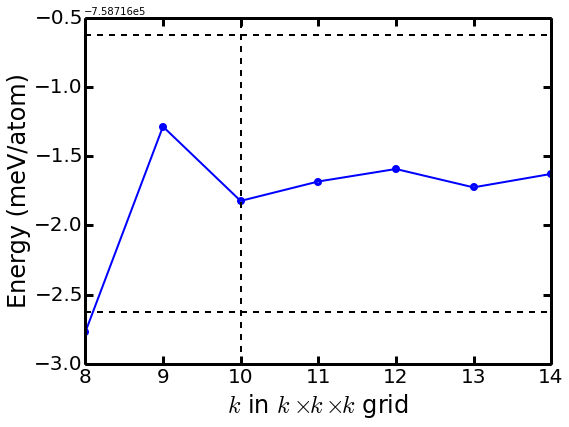

In [7]:
b3a = BasicAnalyzer('bcc_af.csv','nkpts',0.5)
df3a = analyze_kgrid(b3a)
plt3a = get_convergence_plot(df3a,'kgrid','energy',1)
plt3a.xlabel('$k$ in $k\\times k\\times k$ grid')
plt3a.ylabel('Energy (meV/atom)')
plt3a.tight_layout()
plt3a.savefig('bcc_af_kpts.pdf')

In [8]:
b3f = BasicAnalyzer('bcc_latt.csv')
df3f = b3f.df
ef = df3f[df3f.alat==2.841804]['energy']
eaf = b3a['energy'][-1]
print float(eaf - ef)

513.238841338
